In [1]:
#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#If it prints "cuda:0" that means it has access to GPU. If it prints out "cpu", then it's still running on CPU.

cpu


In [6]:
from os import listdir, walk
from os.path import isfile, join
from pathlib import Path
from functools import reduce

In [8]:
train = pd.read_csv(r'C:\Users\Jan\Downloads\train.csv')
test = pd.read_csv(r'C:\Users\Jan\Downloads\test.csv')

#Let's check if they have been loaded properly
print('train.shape:\n', train.shape)
print('test.shape:\n', test.shape)

train.shape:
 (42000, 785)
test.shape:
 (28000, 784)


In [10]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1:] #Could have done like this 
y = train.label.values # but needed to convert it to np.ndarray for torch tensor conversion

In [11]:
print('X.shape: ', X.shape, 'X.type: ', type(X) )
print('y.shape: ', y.shape, 'y.type: ', type(y) )

X.shape:  (42000, 784) X.type:  <class 'pandas.core.frame.DataFrame'>
y.shape:  (42000,) y.type:  <class 'numpy.ndarray'>


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state = 1)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (37800, 784)
y_train.shape:  (37800,)
X_test.shape:  (4200, 784)
y_test.shape:  (4200,)


In [13]:
#Rescaling values
X_train = X_train.values/255
X_test = X_test.values/255

In [14]:
#Converting to Tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

print('X_train.dtype:', X_train.dtype)
print('X_test.dtype:', X_test.dtype)
print('y_train.dtype:', y_train.dtype)
print('y_test.dtype:', y_test.dtype)

X_train.dtype: torch.float64
X_test.dtype: torch.float64
y_train.dtype: torch.int64
y_test.dtype: torch.int64


In [15]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

batch = 100

# Set our data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size = batch, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True)

In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        
        x = x.view(-1,224*4*4)
        
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        
        x = self.softmax(self.fc5(x))
        
        return x

print(Net()) 

Net(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [17]:
#Making an object of the Net class
model = Net().to(device)

#Loss function
criterion = nn.CrossEntropyLoss ()

In [18]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0015)

In [21]:
# Initialising variables
epochs = 3
steps = 0
print_every = 100
trainLoss = [] 
testLoss = []

In [22]:
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1   # Forward pass
        
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        optimizer.zero_grad()
        log_ps = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = criterion(log_ps, labels)
        loss.backward()   # Backward pass
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
                    log_ps = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    test_loss += criterion(log_ps, labels)
                    ps = torch.exp(log_ps)
                    
                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            trainLoss.append(running_loss/len(train_loader))
            testLoss.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, epochs),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/3..  Test Accuracy: 0.965
Epoch: 1/3..  Test Accuracy: 0.960
Epoch: 1/3..  Test Accuracy: 0.969
Epoch: 2/3..  Test Accuracy: 0.972
Epoch: 2/3..  Test Accuracy: 0.972
Epoch: 2/3..  Test Accuracy: 0.968
Epoch: 2/3..  Test Accuracy: 0.971
Epoch: 3/3..  Test Accuracy: 0.974
Epoch: 3/3..  Test Accuracy: 0.974
Epoch: 3/3..  Test Accuracy: 0.975
Epoch: 3/3..  Test Accuracy: 0.968


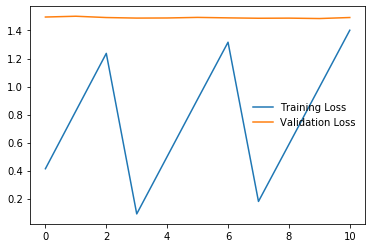

In [23]:
%matplotlib inline

plt.plot(trainLoss, label = 'Training Loss')
plt.plot(testLoss, label = 'Validation Loss')
plt.legend(frameon = False)

In [25]:
test = pd.read_csv(r'C:\Users\Jan\Downloads\test.csv')

finalTest = test.values/255

finalTest = torch.from_numpy(finalTest)

temp = np.zeros(finalTest.shape)
temp = torch.from_numpy(temp)

data = torch.utils.data.TensorDataset(finalTest, temp)

submissionLoader = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = False)

submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in submissionLoader:
        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
        log_ps = model(images.type(torch.FloatTensor).to(device))
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1
            


pytorchSubmission = pd.DataFrame(submission)
pytorchSubmission.columns = pytorchSubmission.iloc[0]
pytorchSubmission = pytorchSubmission.drop(0, axis = 0)

pytorchSubmission.to_csv("submission.csv", index = False)